In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
from matplotlib.ticker import FormatStrFormatter
import re
import os
from scipy.optimize import curve_fit
from matplotlib.gridspec import GridSpec
import math

In [2]:
# Convert .txt file to .csv file
txt_files = ['Figure 2 (4953).txt']
columns = ['Date__(UT)__HR:MN', '', '', ' R.A._(ICRF)', 'DEC__(ICRF)', 'delta', '     deldot', '']

for file_path in txt_files:
    start_marker = "$$SOE"
    end_marker = "$$EOE"
    
    with open(file_path, 'r') as file:
        data_lines = []
        is_data = False 
        
        for line in file:
            if start_marker in line:
                is_data = True
            elif end_marker in line:
                is_data = False
            elif is_data:
                data_lines.append(line.strip())
    
    data = [line.split(",") for line in data_lines]
    max_columns = max(len(row) for row in data)
    data = [row + [''] * (max_columns - len(row)) for row in data]
    df = pd.DataFrame(data, columns=columns)
    
    base_name = os.path.splitext(os.path.basename(file_path))[0]
    csv_file_path = f'{base_name}.csv'
    df.to_csv(csv_file_path, index=False)
    print(f"Excel file saved: {csv_file_path}")

Excel file saved: Figure 2 (4953).csv


In [3]:
file_path = 'Figure 2 (4953).csv'
data = pd.read_csv(file_path)
print(data.to_string(index=False))

 Date__(UT)__HR:MN Unnamed: 1 Unnamed: 2   R.A._(ICRF)  DEC__(ICRF)    delta       deldot  Unnamed: 7
      2.460614e+06          A                 11.41741    -36.81121 1.146946    -0.504864         NaN
      2.460614e+06                            11.39445    -36.80887 1.146934    -0.424518         NaN
      2.460614e+06                            11.37143    -36.80644 1.146925    -0.333521         NaN
      2.460614e+06                            11.34838    -36.80392 1.146918    -0.237308         NaN
      2.460614e+06                            11.32535    -36.80130 1.146914    -0.141674         NaN
      2.460614e+06                            11.30237    -36.79859 1.146911    -0.052372         NaN
      2.460614e+06                            11.27949    -36.79579 1.146911     0.025274         NaN
      2.460614e+06                            11.25673    -36.79292 1.146913     0.086743         NaN
      2.460614e+06                            11.23413    -36.79000 1.146915     0

In [4]:
jd_adjusted = data['Date__(UT)__HR:MN']
jd_binned_median = jd_adjusted - jd_adjusted.min()

ra_deg_adjusted_detected = data[' R.A._(ICRF)']

print(f"{'JD Adjusted':<25}{'RA Adjusted Detected':<25}")
print("=" * 75)

for jd, ra in zip(jd_binned_median, ra_deg_adjusted_detected):
    print(f"{jd:<25.10f}{ra:<25.10f}")

JD Adjusted              RA Adjusted Detected     
0.0000000000             11.4174100000            
0.0416666670             11.3944500000            
0.0833333330             11.3714300000            
0.1250000000             11.3483800000            
0.1666666670             11.3253500000            
0.2083333330             11.3023700000            
0.2500000000             11.2794900000            
0.2916666670             11.2567300000            
0.3333333330             11.2341300000            
0.3750000000             11.2116900000            
0.4166666670             11.1894300000            
0.4583333330             11.1673200000            
0.5000000000             11.1453700000            
0.5416666670             11.1235300000            
0.5833333330             11.1017800000            
0.6250000000             11.0800800000            
0.6666666670             11.0583800000            
0.7083333330             11.0366500000            
0.7500000000             11.014

In [5]:
#  Equation 5
def fit_function_linear(x, A, B, C, D, E):
    return A * np.sin(2 * np.pi * x + B) + C * x + D + E * x**2

params_sine, covariance_sine = curve_fit(fit_function_linear, jd_binned_median, ra_deg_adjusted_detected)
print(f"\033[1;32m Equation 1: sine +linear terms (Paramters):     {params_sine}\033[0m")

# Uncertainties in Equation 5
sine_uncertainties = np.sqrt(np.diag(covariance_sine))
print(f"\033[1;32m Equation 1: sine +linear terms (Uncertainities):{sine_uncertainties}\033[0m")

 Equation 1: sine +linear terms (Paramters):     [ 2.30624840e-03  2.40703388e+00 -5.39828447e-01  1.14159015e+01
  3.75439904e-03]
 Equation 1: sine +linear terms (Uncertainities):[3.04482951e-06 1.33151970e-03 1.43580680e-05 6.15387513e-06
 7.06409598e-06]


In [6]:
amplitude_deg = params_sine[0]
amplitude_rad = math.radians(amplitude_deg)
print(f"\033[1;32mamplitude (rad):              {amplitude_rad}\033[0m")
 
amplitude_uncertainty_deg = sine_uncertainties[0]
amplitude_uncertainty_rad = math.radians(amplitude_uncertainty_deg)
print(f"\033[1;32mamplitude uncertianity (rad): {amplitude_uncertainty_rad}\033[0m")

amplitude (rad):              4.025162796339364e-05
amplitude uncertianity (rad): 5.3142300134195665e-08


In [7]:
earth_radius_km = 6371  

distance_km = earth_radius_km / amplitude_rad

distance_uncertainty_km = (earth_radius_km/amplitude_rad) * (amplitude_uncertainty_rad/abs(amplitude_rad))

print(f"\033[1;32mEquation 3: Distance_km: {abs(distance_km):.2f} ± {abs(distance_uncertainty_km):.2f}\033[0m")

Equation 3: Distance_km: 158279312.47 ± 208968.61


In [8]:
latitude_deg = 30.1732 
latitude_rad = math.radians(latitude_deg)
print("Latitude (rad):              ", latitude_rad)

Latitude (rad):               0.526621685862753


In [9]:
dec_deg = data['DEC__(ICRF)'][0]
dec_rad = math.radians(dec_deg)
print("DEC (rad):                   ", dec_rad)

DEC (rad):                    -0.6424768161430618


In [10]:
asteroid_km = (distance_km * math.cos(latitude_rad)) / math.cos(dec_rad)

asteroid_uncertainty_km = asteroid_km * (distance_uncertainty_km / distance_km)

print(f"\033[1;32mEquation 4: Asteroid Distance (km):{abs(asteroid_km):.2f} ± {abs(asteroid_uncertainty_km):.2f}\033[0m")

Equation 4: Asteroid Distance (km):170911351.61 ± 225646.09


In [11]:
km_to_au = 149597870.7

asteroid_dist_au = asteroid_km / km_to_au

asteroid_dist_uncertainty_au = asteroid_uncertainty_km / km_to_au

print(f"\033[1;32mAsteroid Distance (AU):{abs(asteroid_dist_au):.6f} ± {abs(asteroid_dist_uncertainty_au):.6f}\033[0m")

Asteroid Distance (AU):1.142472 ± 0.001508


In [12]:
delta = data['delta']
true_distance = delta.mean()
print(f"\033[1;32mNASA JPL Horizons True distance (AU): {true_distance}\033[0m")

NASA JPL Horizons True distance (AU): 1.1469131504435228


In [13]:
if asteroid_dist_au == 0 or true_distance == 0:
    print("\033[1;31mError: One of the values is zero, cannot compute percentage difference.\033[0m")
else:
    percentage_difference = abs(abs(asteroid_dist_au) - abs(true_distance)) / ((abs(asteroid_dist_au) + abs(true_distance)) / 2) * 100
    print(f"\033[1;32mAsteroid Distance Difference between True and Predicted: {percentage_difference:.6f}%\033[0m")

Asteroid Distance Difference between True and Predicted: 0.387993%


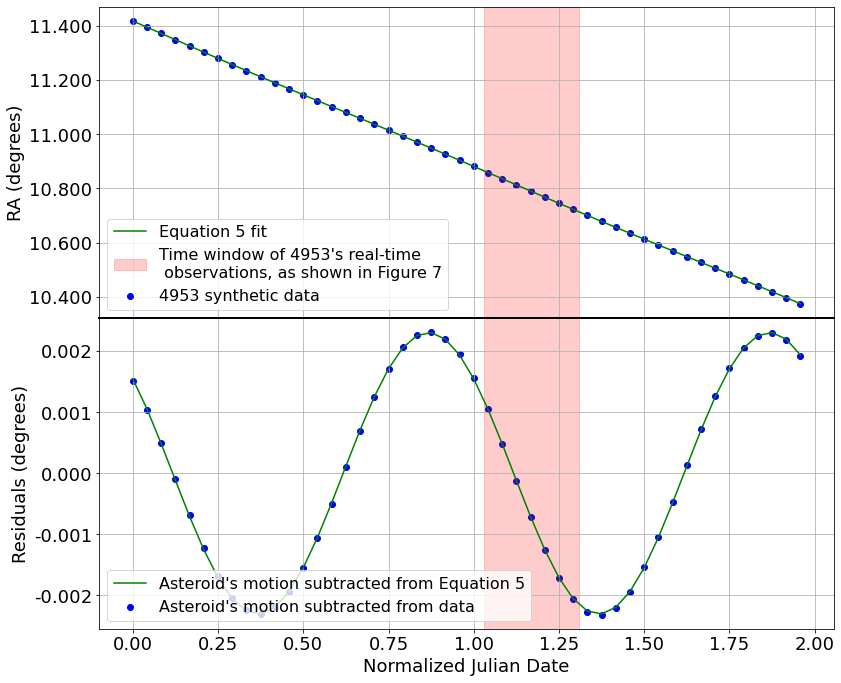

In [14]:
radians_to_degrees = 180 / np.pi

fig = plt.figure(figsize=(12, 13.55))
gs = GridSpec(3, 1, height_ratios=[1.5, 1.5, 1], figure=fig)

# Subplot 1: 
ax1 = fig.add_subplot(gs[0, 0])

ax1.scatter(jd_binned_median, ra_deg_adjusted_detected, color='blue', label = '4953 synthetic data')
ax1.plot(jd_binned_median, fit_function_linear(jd_binned_median, *params_sine), color='green', label = 'Equation 5 fit')
ax1.axvspan(1.031, 1.308, color='red', alpha=0.2, label="Time window of 4953's real-time \n observations, as shown in Figure 7")

ax1.tick_params(axis='both', which='major', labelsize=18)
ax1.set_ylabel("RA (degrees)", fontsize=18)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax1.set_xticklabels([])
ax1.legend(fontsize=16)
ax1.grid()

# Subplot 2: 
ax2 = fig.add_subplot(gs[1, 0])

ax2.plot(jd_binned_median, 
         fit_function_linear(jd_binned_median, *params_sine) - (params_sine[2]*jd_binned_median + params_sine[3] + params_sine[4]*jd_binned_median**2), 
         color = 'green', label = 'Asteroid\'s motion subtracted from Equation 5')
ax2.scatter(jd_binned_median, ra_deg_adjusted_detected - (params_sine[2]*jd_binned_median + params_sine[3] + params_sine[4]*jd_binned_median**2), 
            color = 'blue', label = 'Asteroid\'s motion subtracted from data')
ax2.axvspan(1.031, 1.308, color='red', alpha=0.2)

ax2.tick_params(axis='both', which='major', labelsize=18)
ax2.set_xlabel("Normalized Julian Date", fontsize=18)
ax2.set_ylabel("Residuals (degrees)", fontsize=18) 
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax2.legend(fontsize=16, loc='lower left')
ax2.grid()

plt.subplots_adjust(hspace=0)
plt.gcf().axes[0].spines['bottom'].set_linewidth(2)
plt.gcf().axes[1].spines['top'].set_linewidth(2)

plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, wspace=0.1, hspace=0)
plt.savefig("Figure 2.png", format="png", dpi=300, bbox_inches="tight", facecolor='white')

plt.show()